In [1]:
import os, sys
import pickle as pkl
import pandas as pd
import numpy as np 

import sklearn
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import sgml, sgnn

import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

print(sys.version)

for i in [pd, np, sklearn, sns, lgb, xgb, cb]:
    print(i.__name__, i.__version__)

2024-05-17 07:08:04.636073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 07:08:05.194969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


3.12.3 (main, May  7 2024, 08:28:12) [GCC 9.4.0]
pandas 2.2.2
numpy 1.26.4
sklearn 1.4.2
seaborn 0.13.2
lightgbm 4.3.0
xgboost 2.0.3
catboost 1.2.5


In [2]:
data_path = 'data'
img_path = 'img'
result_path = 'result'
if not os.path.isdir(img_path):
    os.mkdir(img_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('org', data_path, 'flood.csv'),
        ('test', data_path, 'test.csv'),
        ('type', data_path, 'type.pkl'),
        ('train_pkl', data_path, 'train.pkl'),
        ('org_pkl', data_path, 'org.pkl'),
        ('test_pkl', data_path, 'test.pkl'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

df_var = pd.read_pickle(files['var_pkl'])
df_train = pd.read_pickle(files['train_pkl'])
df_org = pd.read_pickle(files['org_pkl'])
df_test = pd.read_pickle(files['test_pkl'])

In [29]:
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split

cv5 = KFold(n_splits=5, random_state=123, shuffle=True)

def predict(m, df, X):
    return pd.Series(m.predict(df[X]), index=df.index)

def lgb_r2(pr, tr):
    return 'r2', r2_score(tr, pr), True

def eval_metric(df, y_prd):
    return r2_score(df['FloodProbability'], y_prd)

def valid_splitter(df):
    return train_test_split(df, train_size=0.8, random_state=123)

def print_metrics(valid_metrics, train_metrics):
    print('Valid.: {:.5f}±{:.5f}, Train: {:.5f}±{:.5f}'.format( 
        np.mean(valid_metrics), np.std(valid_metrics),
        np.mean(train_metrics), np.std(train_metrics),
    ))

def show_gb_cv_result(gb_result, train_result, metric='r2'):
    if train_result is not None:
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        df = pd.concat([i[0] for i in train_result], axis=0)[metric].reset_index().rename(columns={'index': 'round'}).groupby('round').mean()
        sns.lineplot(df.loc[df['training'] > 0], ax=axes[0])
        sns.barplot(
            pd.concat([i[1] for i in train_result], axis=0).rename('importance').reset_index().rename(columns={'index': 'feature'})\
                .groupby('feature').mean().sort_values('importance', ascending=False).iloc[:15],
            x='importance', y='feature', ax=axes[1]
        )
        plt.tight_layout()
        plt.show()
        print_metrics(gb_result['valid_metrics'], gb_result['train_metrics'])

stk = sgml.SGStacking(df_train, 'FloodProbability', sp=cv5, predict_func=predict, eval_metric=eval_metric, greater_better=True)

In [9]:
X_num_org = df_var.loc[(~df_var.index.isin(['id', 'FloodProbability'])) & (df_var['src'] == 'org')].index.tolist()
X_sort = df_var.loc[df_var['src'] == 'sort'].index.tolist()
X_sum = df_var.loc[df_var.index.map(lambda x: x.startswith('s_'))].index.tolist()

# LightGBM

In [5]:
lgb_eval = partial(stk.eval_model, model=lgb.LGBMRegressor, result_proc=sgml.lgb_learning_result)

In [38]:
m, train_result = lgb_eval(
    'lgb1', model_params={'verbose': -1}, X=X_num_org + X_sort + X_sum, 
    result_proc=sgml.lgb_learning_result,
    train_params={
        'fit_params': {'callbacks': [lgb.early_stopping(5, verbose=False)], 'eval_metric': lgb_r2},
        'valid_splitter': valid_splitter,
        'valid_config_proc': sgml.gb_valid_config
    }
)

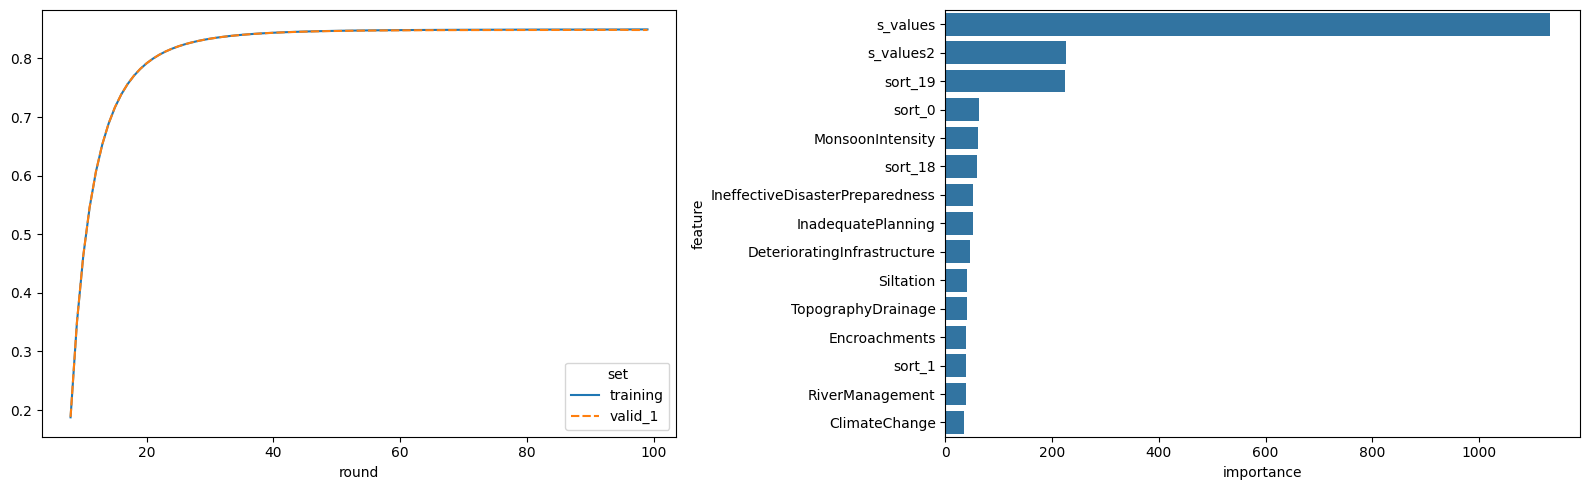

Valid.: 0.86875±0.00026, Train: 0.86937±0.00007


In [50]:
show_gb_cv_result(m, train_result)

In [42]:
train_result

[(metric        l2         r2        l2         r2
  set     training   training   valid_1    valid_1
  0       0.002178 -95.503983  0.002172 -95.492032
  1       0.001830 -21.475104  0.001826 -21.473061
  2       0.001549  -8.350681  0.001545  -8.351401
  3       0.001321  -3.951955  0.001318  -3.953014
  4       0.001136  -2.004114  0.001133  -2.004750
  ..           ...        ...       ...        ...
  90      0.000340   0.849484  0.000342   0.848116
  91      0.000340   0.849494  0.000342   0.848108
  92      0.000340   0.849515  0.000342   0.848118
  93      0.000340   0.849541  0.000342   0.848129
  94      0.000340   0.849555  0.000342   0.848127
  
  [95 rows x 4 columns],
  sort_10                               8
  sort_12                              12
  sort_8                               12
  sort_6                               12
  sort_7                               13
  sort_16                              14
  sort_13                              15
  sort_14      

In [18]:
cv_result